In [1]:
from matplotlib import pyplot as plt
import numpy as np

from sigproc_kit import *

from my_utils import *

In [2]:
def ana_rot(I,Q,itime,**kwargs):


    phi = np.arctan2(Q,I)
    
    rotations   = np.array([])
    gap_centers = np.array([])


    plot = kwargs.get("plot",False)
    
    last_gap_center = 0
    rotation = 0
    
    my_range = int(np.max(itime))+1
    
    last_start_of_block = -1000
    last_end_of_block   = -1000
    last_block_center   = -1000
    last_block_over_gap      = False
    

    for i in range(my_range):
        mask = (itime == i)
        phiset=phi[mask]
        
        
        if(plot):
            print("i = {}".format(i))
            plt.hist(phiset,bins=np.arange(-3.2,3.2,.1))
            plt.show()
            
        gap_center = 0
            
        if len(phiset) > 0:
        
            phiset.sort()
            
            rot_phiset = np.concatenate((phiset[1:],phiset[:1])) 
            
            distance = (rot_phiset - phiset) % (2*np.pi)
            
            end_of_block = phiset[np.argmax(distance)]
            start_of_block = phiset[ (np.argmax(distance)+1) % len(phiset) ]
            max_distance  = np.max(distance)
            block_width   = 2*np.pi - max_distance
            gap_center = ((end_of_block + max_distance/2 + np.pi) % (2*np.pi)) - np.pi
            block_center = ((start_of_block + block_width/2 + np.pi) % (2*np.pi)) - np.pi
            #plt.plot(distance)
            #plt.show()
            if(0):
                print("gap distance: {}".format(max_distance))
                print("start of block: {}".format(start_of_block))
                print("end of block: {}".format(end_of_block))
                print("gap center: {}".format(gap_center))
                print("block center: {}".format(block_center))
            
            block_over_gap = block_center > gap_center
            
            #if (last_block_over_gap == False) and (block_over_gap == True):
                #rotation += 1
            if gap_center < last_gap_center:
                rotation += 1
                
            #print("counted rotations: {}".format(rotation))
            
            last_gap_center     = gap_center
            last_start_of_block = start_of_block
            last_end_of_block   = end_of_block
            last_block_center   = block_center
            last_block_over_gap = block_over_gap
            
        gap_centers = np.append(gap_centers,[gap_center])
        rotations   = np.append(rotations,[rotation])
        
    #print(gap_centers)
   
    if(True):
        idx = list(range(my_range))
        plt.plot(idx,rotations)
        plt.scatter(idx,rotations,label="rotations")
        plt.plot(idx,gap_centers)
        plt.scatter(idx,gap_centers,label="gap centers")
        plt.title("unfolding analysis")
        plt.legend()
        plt.xlabel("intermediate time")
        plt.show()
        
    return (rotations,gap_centers)

def cont_phi_new(I,Q,itime,rotations,gap_centers):
    
    phi = np.arctan2(Q,I)
    
    new_phi = np.zeros(len(phi))
    
    for i, phival in enumerate(phi):
        
        index = int(itime[i]) 
        if phival >= gap_centers[index]: # the lower valued part
                new_phi[i] = phival  + (rotations[index])*2*np.pi
        else: # higher valued part
                new_phi[i] = phival  + (rotations[index]+1)*2*np.pi
        
        
        
    return new_phi + np.pi

In [3]:
def evolve_tdl(tdl,new_input):
    
    speed_up = 1.1
    speed_down = 0.35
    
    
    
    left_neighbor = np.concatenate((np.array([new_input]),tdl[:-1]), axis=None)
    
    left_neighbor_one  = (left_neighbor >= 1) 
    left_neighbor_zero = (left_neighbor <= 0) 
    different_from_left_neighbor = (tdl != left_neighbor)
    
    tdl += (left_neighbor_one  * different_from_left_neighbor)*speed_up
    tdl -= (left_neighbor_zero * different_from_left_neighbor)*speed_down
    
    tdl[ tdl > 1] = 1
    tdl[ tdl < 0] = 0
    
        
    return tdl
        

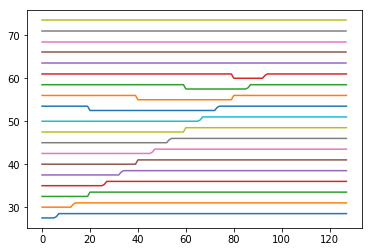

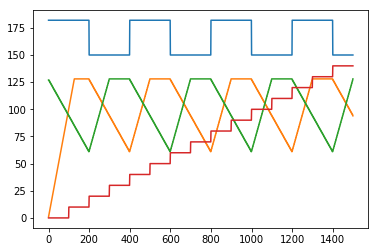

In [17]:
tdl_a = np.zeros(128)
tdl_b = np.ones(128)

tsteps = 1500

mem_a = np.zeros(tsteps)
mem_b = np.zeros(tsteps)

mem_a0 = np.zeros(tsteps)
mem_b0 = np.zeros(tsteps)

mem_aa = np.zeros(tsteps)
mem_ab = np.zeros(tsteps)
mem_ba = np.zeros(tsteps)
mem_bb = np.zeros(tsteps)
mem_in = np.zeros(tsteps)

inter_cnt = 0
mem_inter = np.zeros(tsteps)

osc_period = 200
new_input = False

c = 0

for i in range(tsteps):
    
    if (i % osc_period) == 0:
        new_input = not(new_input)
        
    
    if (i % 20) == 0:
        if c > 10 and c <30:
            plt.plot(tdl_a+c*2.5)
        c+=1
    
    
    if i % 100 == 0 and i > 0:
        inter_cnt += 1
    
    new_input_a = new_input
    new_input_b = not(new_input)
    
    tdl_a = evolve_tdl(tdl_a,int(new_input_a))
    tdl_b = evolve_tdl(tdl_b,int(new_input_b))
    
    
    tdl_aa = tdl_a[:96]
    tdl_ab = tdl_a[32:]
    tdl_ba = tdl_b[:96]
    tdl_bb = tdl_b[32:]
    
    mem_a[i] = np.sum( tdl_a >= 1 )
    mem_b[i] = np.sum( tdl_b >= 1 )
    
    mem_inter[i] = inter_cnt
    
    mem_aa[i] = np.sum( tdl_aa > 0 )
    mem_ab[i] = np.sum( tdl_ab > 0 )
    mem_ba[i] = np.sum( tdl_ba > 0 )
    mem_bb[i] = np.sum( tdl_bb > 0 )
    
    mem_in[i] = new_input
    
    mem_a0[i] = tdl_a[0] >= 1
    mem_b0[i] = tdl_b[0] >= 1
    
plt.show()

plt.plot(mem_in*32+ 150)
plt.plot(mem_a,label="pop a")
plt.plot(mem_b,label="pop b")
plt.plot(mem_inter*10)
plt.show()

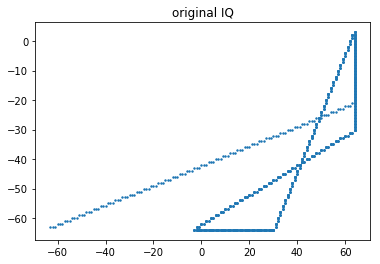

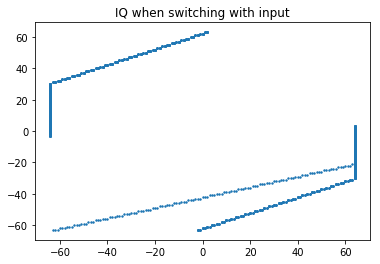

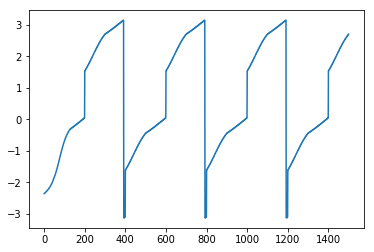

In [18]:
I = mem_a - 64
Q = -(mem_b - 64)

plt.scatter(I,Q,s=2)
plt.title("original IQ")
plt.show()

#I_mod = I*(mem_in > 0)
#Q_mod = Q*(mem_in > 0)
#
#plt.scatter(I_mod,Q_mod,s=2)
#plt.title("IQ when mem_in == 1")
#plt.show()
#
#I_mod = I*(mem_in < 1)
#Q_mod = Q*(mem_in < 1)
#
#plt.scatter(I_mod,Q_mod,s=2)
#plt.title("IQ when mem_in == 0")
#plt.show()


#I_mod = I*(mem_in > 0)  +Q * (mem_in < 1 )
#Q_mod = Q*(mem_in > 0)  +I * (mem_in < 1 )

switch = mem_a0

I_mod = I*switch + Q * (switch == False)
Q_mod = Q*switch + I * (switch == False)

plt.scatter(I_mod,Q_mod,s=2)
plt.title("IQ when switching with input")
plt.show()


phi = np.arctan2(Q_mod,I_mod)
plt.plot(phi)

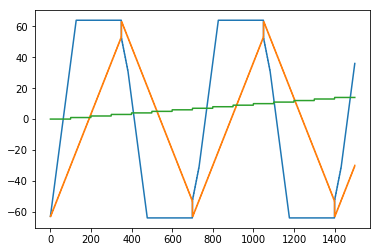

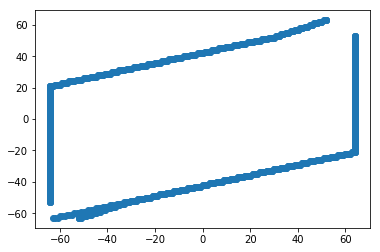

In [18]:
itime = mem_inter

hit_time = list(range(len(I)))

I = I_mod
Q = Q_mod

plt.plot(hit_time,I)
plt.plot(hit_time,Q)
plt.plot(hit_time,itime)


plt.show()

plt.scatter(I,Q)
plt.show()

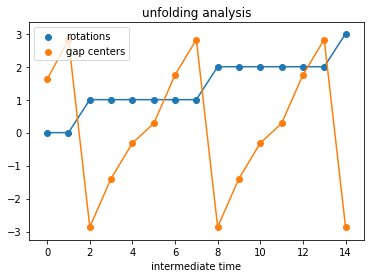

In [14]:
rotations, gap_centers = ana_rot(I,Q,itime,plot=False)

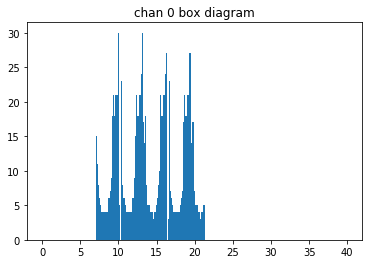

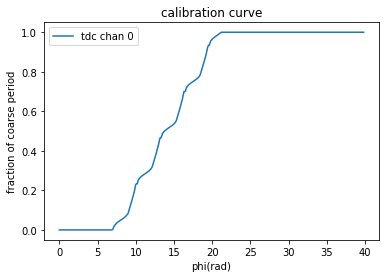

In [19]:
cphi = cont_phi_new(I,Q,itime,rotations,gap_centers)


phistep = 0.1

phirange = 40

hist_a = plt.hist(cphi,bins=np.arange(0,phirange,phistep))
plt.title("chan 0 box diagram")
plt.show()


calib_bins = hist_a[1][:-1]
plt.title("calibration curve")

curve_a = np.cumsum(hist_a[0])/np.sum(hist_a[0])

plt.plot(calib_bins,curve_a,label="tdc chan 0")
plt.legend()
plt.xlabel("phi(rad)")
plt.ylabel("fraction of coarse period")
plt.show()